In [2]:
import sys, os

sys.path.append('/cr/users/filip/bin')

from utils.binaries import *
from utils.plotting import *

from utils.Auger.SD import Monitoring

10:30:43 [INFO] utils          -- (+21662ms) -- import logging
10:30:43 [INFO] utils.binaries -- (  +130ms) -- import numpy as np
10:30:43 [INFO] utils.binaries -- (    +9ms) -- import uncertainties
10:30:43 [INFO] utils.binaries -- (  +182ms) -- import pandas as pd
10:30:43 [INFO] utils.binaries -- (    +1ms) -- import binaries.tools as tools
10:30:43 [INFO] utils.plotting -- (  +368ms) -- import matplotlib.pyplot as plt
10:30:44 [INFO] utils.plotting -- (  +512ms) -- import seaborn as so
10:30:44 [DBUG] utils.plotting -- (    +8ms) -- font size set to 9.5
10:30:44 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
10:30:44 [DBUG] utils.plotting -- (    +2ms) -- figure size set to [6.6, 3.3]
10:30:44 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
10:30:44 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
10:30:44 [INFO] utils.plotting -- (    +3ms) -- import plotting.tools as plot


# Check rates

In [2]:
def read_file(path_to_file : str) -> np.ndarray : 

    import numpy as np, bz2

    wcd_fmt = np.dtype([('timestamp', 'I'), 
                        ('t1_latch_bin', 'h'), 
                        ('vem_peak', ('e', 3)), 
                        ('baseline', ('H', 3)), 
                        ('traces', ('h', (3, 2048)))])
    ssd_fmt = np.dtype([('timestamp', 'I'), 
                        ('t1_latch_bin', 'h'), 
                        ('mip_peak', 'e'), 
                        ('baseline', 'H'), 
                        ('trace', ('h', 2048))])
    
    # requires python 3.10+
    match path_to_file.split('.')[1]:
        case 'ssd': fmt = ssd_fmt
        case 'wcd': fmt = wcd_fmt

    buffer = bz2.BZ2File(path_to_file).read()
    return np.frombuffer(buffer, fmt)

mean_rate = 0
x, y = [],[]

for index in tools.ProgressBar(range(801), newline=False):
    wcd = read_file(f'/cr/data02/AugerPrime/UUB/UubRandoms/2022_11/NuriaJr/randoms{index:04}.wcd.bz2')
    ssd = read_file(f'/cr/data02/AugerPrime/UUB/UubRandoms/2022_11/NuriaJr/randoms{index:04}.ssd.bz2')

    if len(ssd) != 5000 or len(wcd) != 5000:
        print(index)
        continue

    x.append(np.mean(ssd['timestamp']))
    y.append(np.sum(ssd['t1_latch_bin'] != -1) / (len(ssd) * 2048 * 8.33e-9))

running: 801/801[********************] || 00:43:34>00:00:00,         0.31 it/s


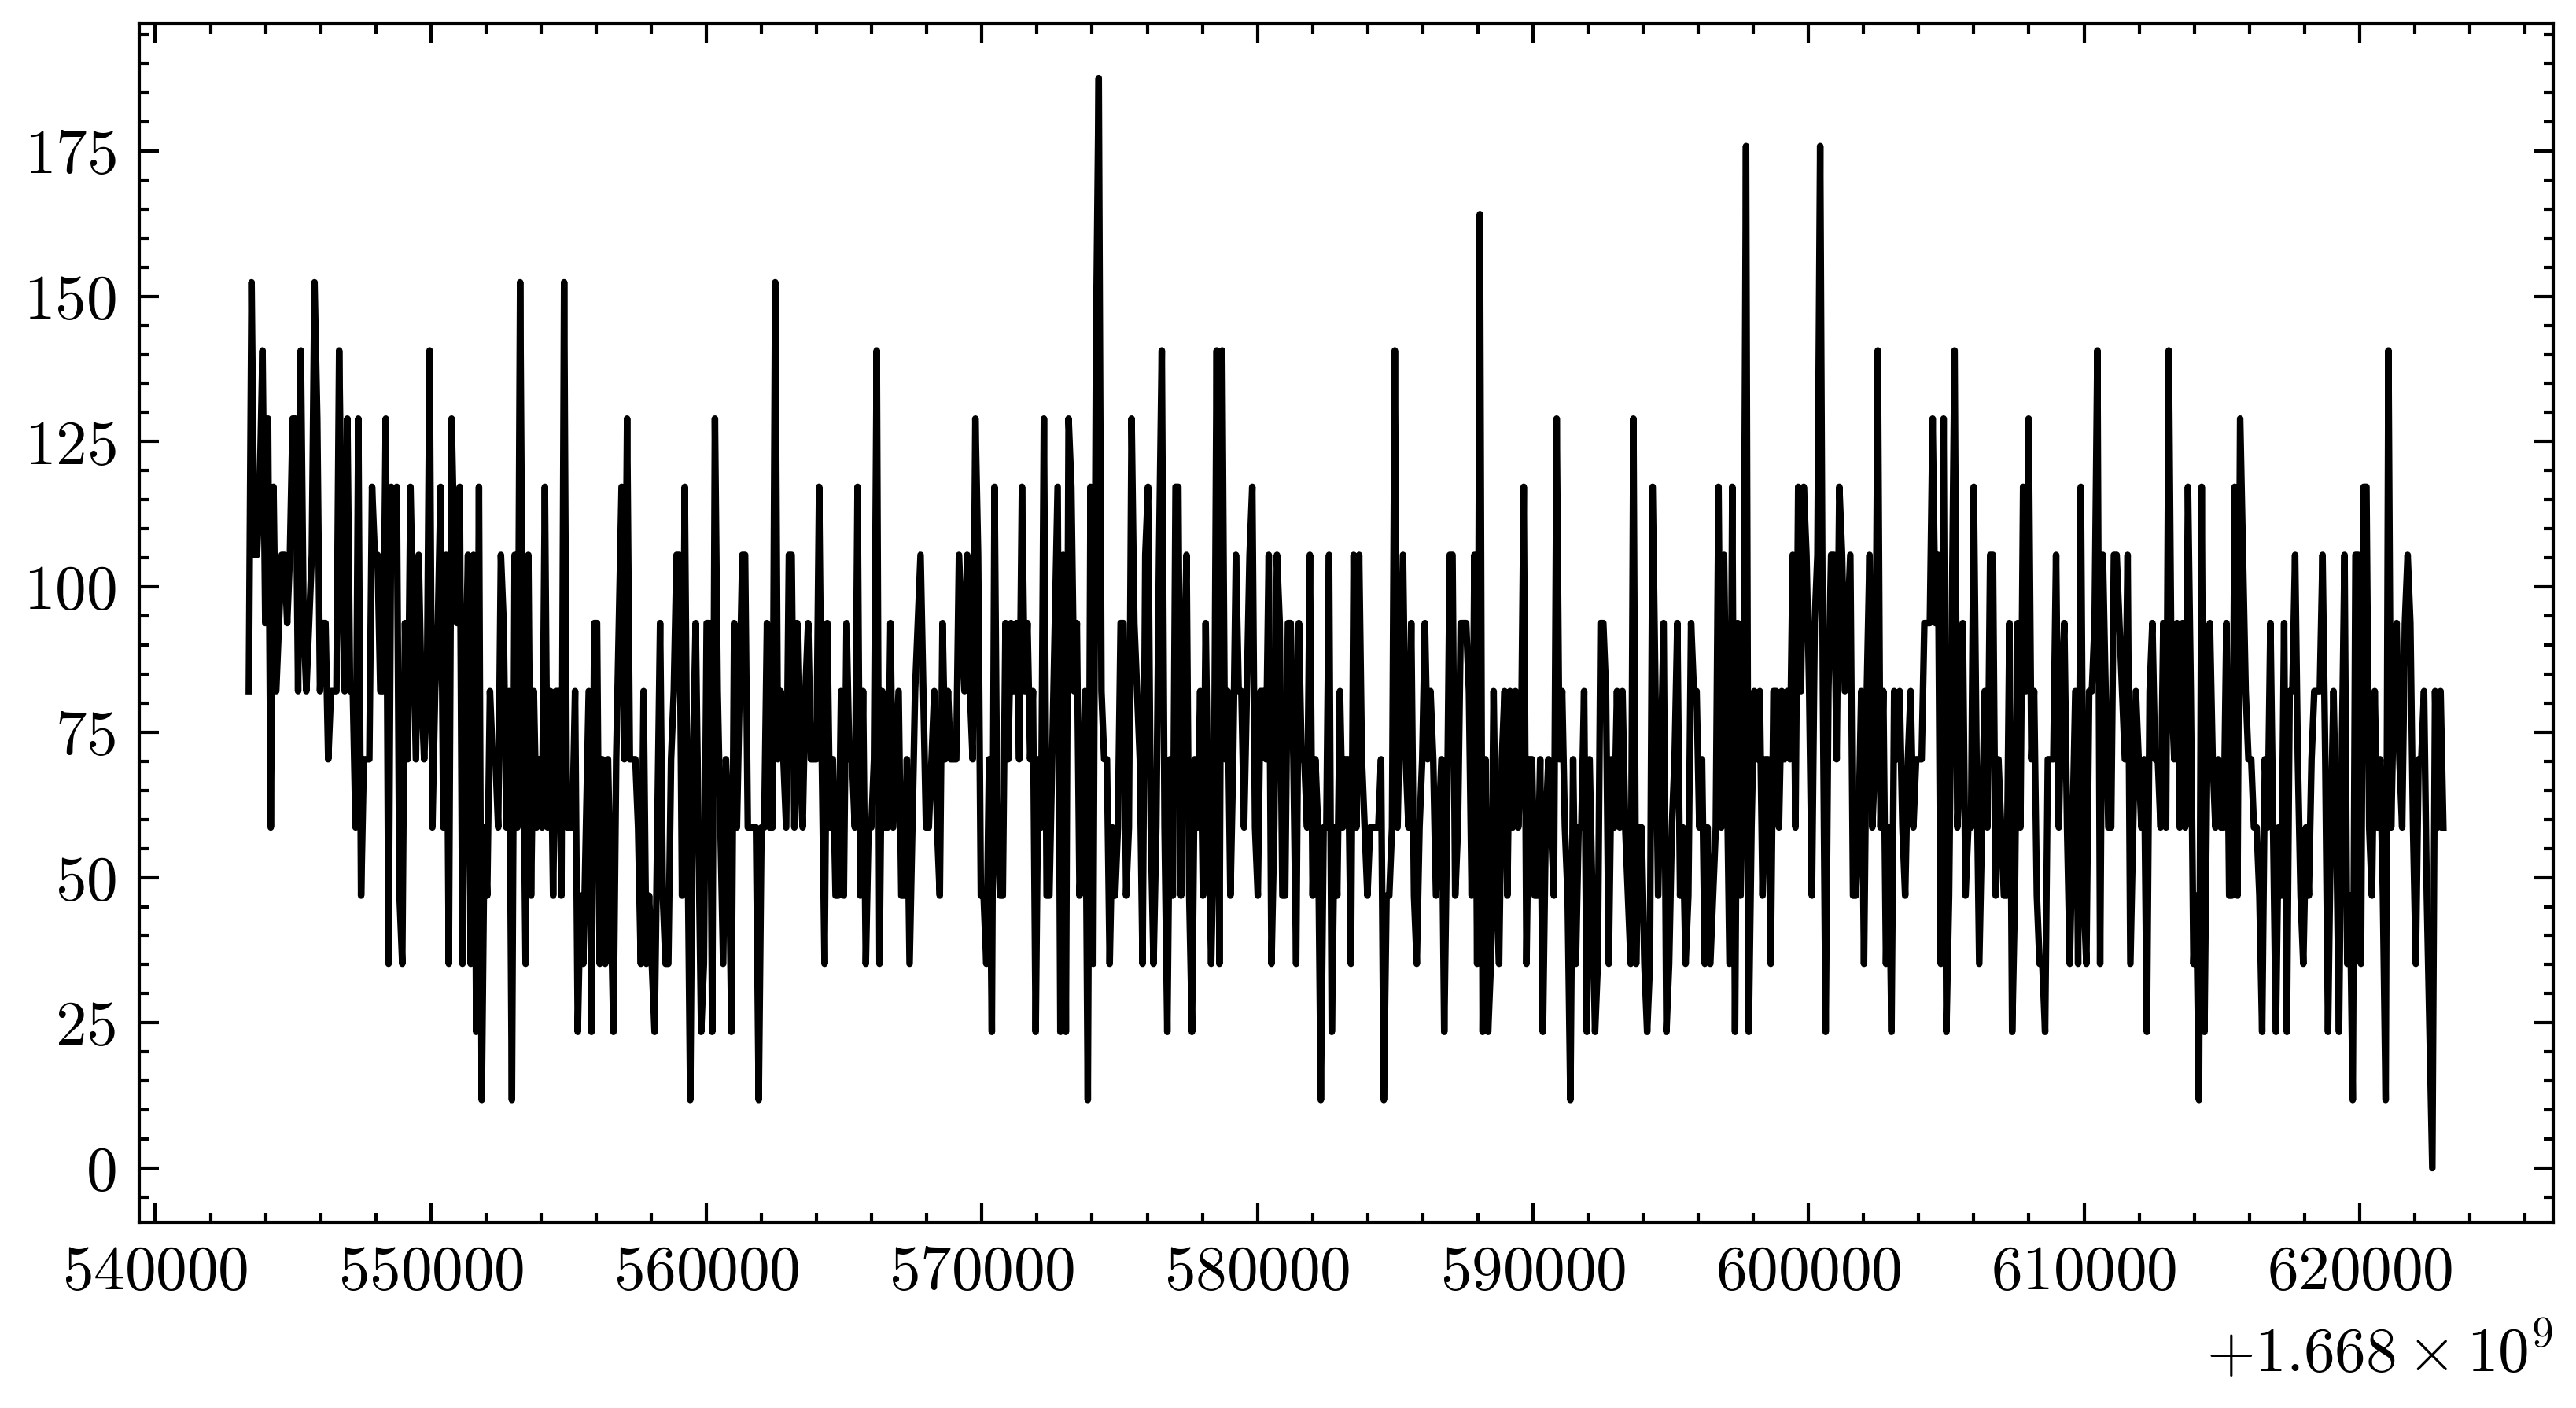

In [3]:
plt.plot(x,y)

In [10]:
data = np.column_stack([x, np.array(y) * (len(ssd) * 2048 * 8.33e-9), y])
np.savetxt('/cr/data02/AugerPrime/UUB/UubRandoms/t1_rates/NuriaJr.txt', data, fmt="%u %u %.3f")


In [9]:
def read_file(path_to_file : str) -> np.ndarray : 

    import numpy as np, bz2

    wcd_fmt = np.dtype([('timestamp', 'I'), 
                        ('t1_latch_bin', 'h'), 
                        ('vem_peak', ('e', 3)), 
                        ('baseline', ('H', 3)), 
                        ('traces', ('h', (3, 2048)))])
    ssd_fmt = np.dtype([('timestamp', 'I'), 
                        ('t1_latch_bin', 'h'), 
                        ('mip_peak', 'e'), 
                        ('baseline', 'H'), 
                        ('trace', ('h', 2048))])
    
    # requires python 3.10+
    match path_to_file.split('.')[1]:
        case 'ssd': fmt = ssd_fmt
        case 'wcd': fmt = wcd_fmt

    buffer = bz2.BZ2File(path_to_file).read()
    return np.frombuffer(buffer, fmt)

In [13]:
wcd_data['timestamp']

array([1668555607, 1668555607, 1668555607, ..., 1668555656, 1668555657,
       1668555657], dtype=uint32)

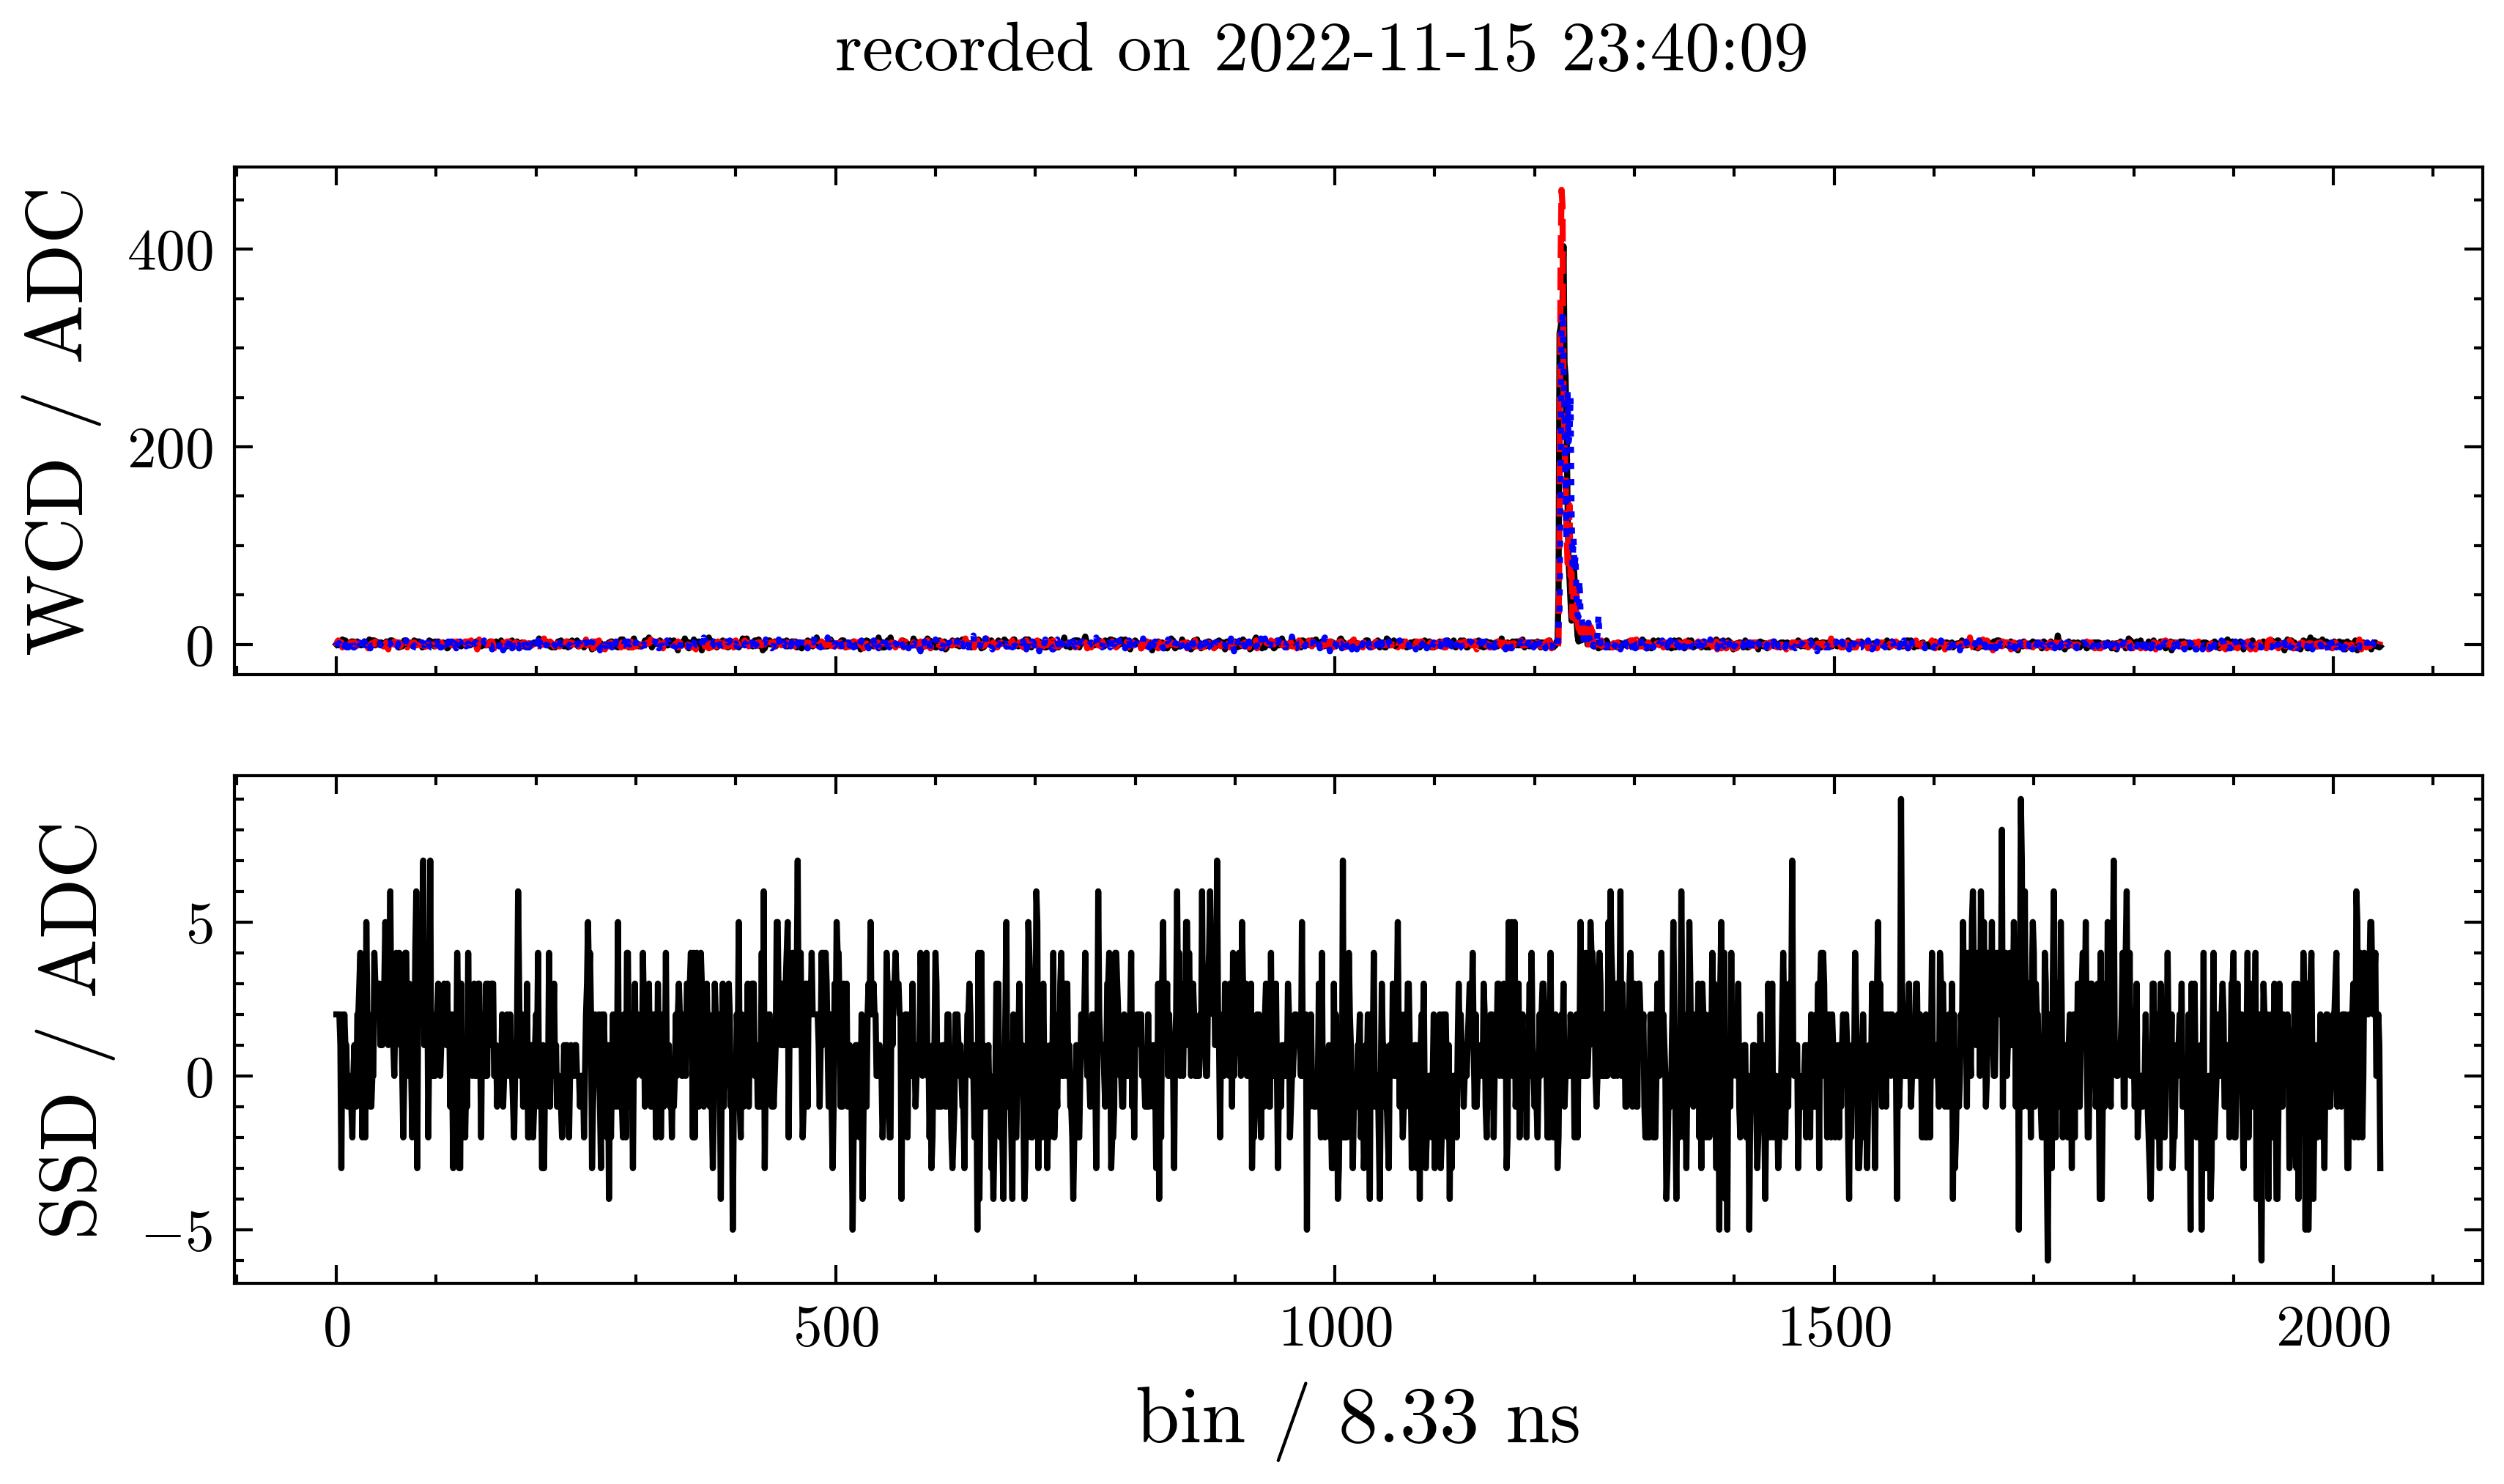

In [14]:
from datetime import datetime

wcd_data = read_file("/cr/data02/AugerPrime/UUB/UubRandoms/2022_11/NuriaJr/randoms0123.wcd.bz2")
ssd_data = read_file("/cr/data02/AugerPrime/UUB/UubRandoms/2022_11/NuriaJr/randoms0123.ssd.bz2")

first_t1_index = np.argmax(ssd_data['t1_latch_bin'] != -1)
first_t1_timestamp = ssd_data[first_t1_index]["timestamp"]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(range(2048), wcd_data[first_t1_index]['traces'][0])    # 1st WCD PMT
ax1.plot(range(2048), wcd_data[first_t1_index]['traces'][1])    # 2nd WCD PMT
ax1.plot(range(2048), wcd_data[first_t1_index]['traces'][2])    # 3rd WCD PMT

ax2.plot(range(2048), ssd_data[first_t1_index]['trace'])        # SSD PMT

fig.suptitle(f'recorded on {datetime.fromtimestamp(first_t1_timestamp)}')
ax1.set_ylabel('WCD / ADC')
ax2.set_xlabel('bin / 8.33 ns')
ax2.set_ylabel('SSD / ADC')

plt.savefig('/cr/users/filip/plots/t1_demonstration.png')

In [8]:
print(len(wcd_data), len(ssd_data))

0 0
